# A model of Salt Identification with Keras ConvNet
Transfer learning will probably be harder with the wonky pictures of salt identification.

In [70]:
# % matplotlib inline
import datetime as dt

# Import plotting for visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import numpy as np
import os
import pandas as pd
import glob
import random, math
import itertools
import tensorflow as tf
import keras
from keras.applications import xception
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate, UpSampling2D
from keras.layers.core import Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, load_model
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm, tqdm_notebook, tnrange
from itertools import chain
import sys
import image as T
sys.path.append("/utils/DLWorkspace-Utils/keras-multiprocess-image-data-generator/tools")
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # for the confusion matrix

import keras.backend as K
K.set_image_data_format('channels_last')

import warnings
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

## First, let's set up our optimizer so we can choose which one later on.

In [71]:
optimizer_collections = {
    "adadelta" : Adadelta(), 
    "nadam" : Nadam(), 
    "rmsprop": RMSprop(), 
    "adam": Adam(), 
    "adagrad": Adagrad(), 
    "adamax": Adamax(), 
}

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', default=16, help='Batch size', type=int)
parser.add_argument('--nb_epochs', default=30, help='Number of Epochs', type=int)
parser.add_argument('--optimizer', default='adam', help='Optimizer', type=str)
parser.add_argument('--split', default=None, help='Which data set to use', type=int)
parser.add_argument('--decay', default=6e-4, help='Rate decay', type=float)
parser.add_argument('--gpus', default=1, help='Number of GPU', type=int)
parser.add_argument('--drops_epochs', default=0, help='Epochs which rate drop by x10', type=float)
parser.add_argument('--lr', default=3e-3, help='Learning Rate', type=float)
parser.add_argument('--epsilon', default=1e-6, help='Optimizer Epsilon', type=float)
parser.add_argument('--rho', default=0.95, help='Optimizer Rho', type=float)
parser.add_argument('--dropout', default=0, help='Dropout', type=float)
parser.add_argument('--reducelr', default=0, help='Reduce learning rate? 0 or 1', type=int)
parser.add_argument('--pooltype', default='max', help='avg or max pool', type=str)
parser.add_argument('--upsample', default=0, help='1? upsample:conv2dtranspose', type=int)

args = parser.parse_args("--optimizer adam --dropout 0.5".split())
#args = parser.parse_args()

print( args )
BATCH_SIZE = 8
if args.batch_size:
    BATCH_SIZE = args.batch_size

num_gpu = args.gpus
# Number of training epochs
EPOCHS = args.nb_epochs
# data to use. 
split = args.split

DO = args.dropout

LR = args.lr
DECAY = args.decay
EPS = args.epsilon
RHO = args.rho

if args.optimizer.startswith("sgd"):
    optimizer = args.optimizer
    opt = SGD(lr = LR, decay=DECAY, momentum=0.9, nesterov=True)
elif args.optimizer.startswith("adam"):
    optimizer = args.optimizer
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=EPS, decay=DECAY)
elif args.optimizer.startswith("adadelta"):
    optimizer = args.optimizer
    opt = Adadelta(lr=LR, rho=RHO, epsilon=EPS, decay=DECAY)  
elif args.optimizer.startswith("rmsprop"):
    optimizer = args.optimizer
    opt = RMSprop(lr=LR, rho=RHO, epsilon=EPS, decay=DECAY)
else:
    optimizer = args.optimizer
    opt = optimizer_collections[args.optimizer]

Namespace(batch_size=16, decay=0.0006, dropout=0.5, drops_epochs=0, epsilon=1e-06, gpus=1, lr=0.003, nb_epochs=30, optimizer='adam', pooltype='max', reducelr=0, rho=0.95, split=None, upsample=0)


### This is a tee object to help write log output.

In [72]:
class Tee(object):
    def __init__(self, name):
        self.file = open(name, "w")
        self.stdout = sys.stdout
        sys.stdout = self
    def __del__(self):
        sys.stdout = self.stdout
        self.file.close()
    def write(self, data):
        self.file.write(data)
        self.stdout.write(data)
    def flush(self):
        self.file.flush()

# Working with our data
First, we locate our data at the correct directories.

In [73]:
data_dir = '/data/kaggle/aerial_cactus_identification/'
cur_dir = '/home/katherineli.kat/kaggle-practice/aerial_cactus_identification/'
result_dir = os.path.join(cur_dir, 'result')
train_dir = os.path.join(data_dir, 'train')
print(train_dir)
test_dir = os.path.join(data_dir, 'test')
#sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
IMAGE_SIZE = 32 # pixel height and width of each image
# we declared our batch size in the argparse, it's 16 for now

/data/kaggle/aerial_cactus_identification/train


Here's a little piece of code if we wanted to test out different lrs and decays
```python
if os.path.isdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay))) == False:
    os.mkdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay)))
    
model_dir = os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay))
```

In [74]:
# Set up location of output
prefix = "8.27"
info = ("_%s_batch%s_epoch%s_dropout%s_pool%s_upsample%s" % (optimizer, BATCH_SIZE, EPOCHS, DO, args.pooltype, args.upsample))

## Checking out our data

In [75]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
TOTAL_PICS = len(os.listdir(train_dir))
print(TOTAL_PICS)
train_df.shape

17500


(17500, 2)

In [76]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [77]:
images = os.path.join(train_dir, "*");
all_images = glob.glob(images)

([], <a list of 0 Text yticklabel objects>)

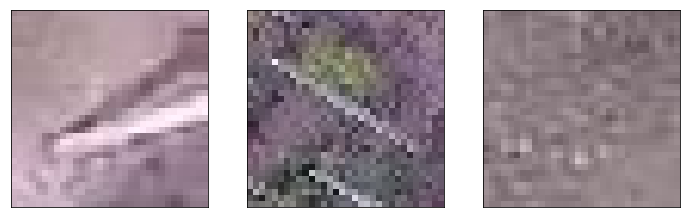

In [78]:
#visualize some images

plt.figure(figsize = (12,10))
plt.subplot(1, 3, 1)
plt.imshow(plt.imread(all_images[0]))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(plt.imread(all_images[10]))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(plt.imread(all_images[20]))
plt.xticks([])
plt.yticks([])

### Let's check the distribution of the data.

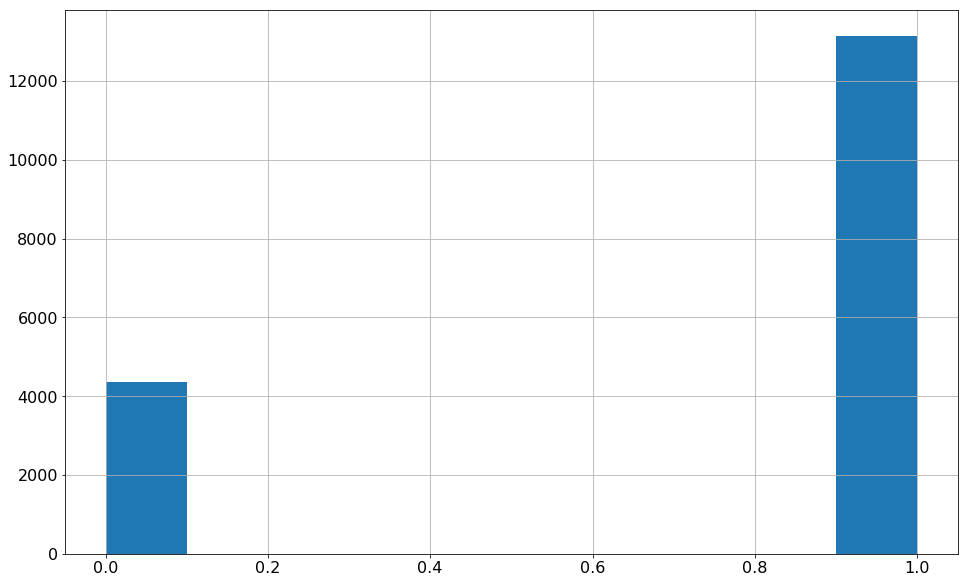

In [79]:
train_df.has_cactus.hist()

From this histogram, we can see that the data is made up of two categories: either 1 and 0. There are a lot more 1s than 0s.

# Now, let's read in the data!
## Training and validations sets first.

In [61]:
def read_img_train(filepath, size):
    img = image.load_img(os.path.join(train_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [62]:
# Let's split our train and validation tests 80/20.
TRAIN_PICS = int(TOTAL_PICS * 0.8)
VALID_PICS = int(TOTAL_PICS * 0.2)
train_x = np.zeros((TRAIN_PICS, IMAGE_SIZE, IMAGE_SIZE, 3))
train_y = np.zeros((TRAIN_PICS))
valid_x = np.zeros((VALID_PICS, IMAGE_SIZE, IMAGE_SIZE, 3))
valid_y = np.zeros((VALID_PICS))
train_count = 0
valid_count = 0
for file in os.listdir(train_dir):
    img = read_img_train(file, (IMAGE_SIZE, IMAGE_SIZE))
    # randomly put images in the train or validation set
    if train_count < TRAIN_PICS:
        if random.randint(0, 9) < 8:
            train_x[train_count] = img/255
            train_y[train_count] = train_df[train_df['id'] == file]['has_cactus'].values[0]
            train_count += 1
        else:
            if valid_count < VALID_PICS:
                valid_x[valid_count] = img/255
                valid_y[valid_count] = train_df[train_df['id'] == file]['has_cactus'].values[0]
                valid_count += 1
            else:
                train_x[train_count] = img/255
                train_y[train_count] = train_df[train_df['id'] == file]['has_cactus'].values[0]
                train_count += 1
    else:
        valid_x[valid_count] = img/255
        valid_y[valid_count] = train_df[train_df['id'] == file]['has_cactus'].values[0]
        valid_count += 1
#train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

Train_x shape: (14000, 32, 32, 3)
Train_y shape: (14000,)


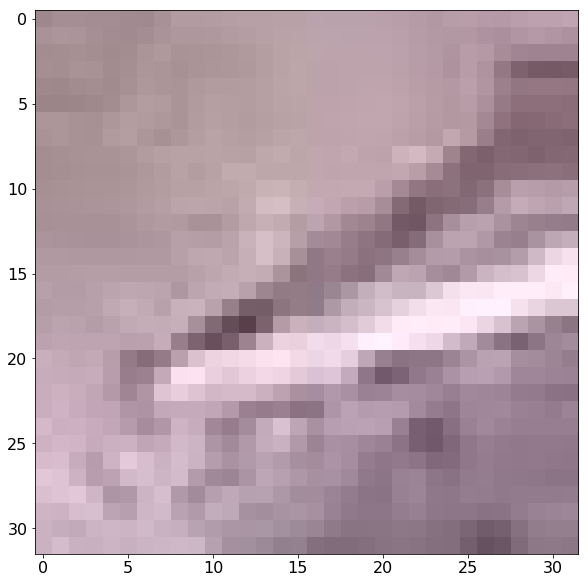

Category: 1.0
Validation set
Valid_x shape: (3500, 32, 32, 3)
Valid_y shape: (3500,)


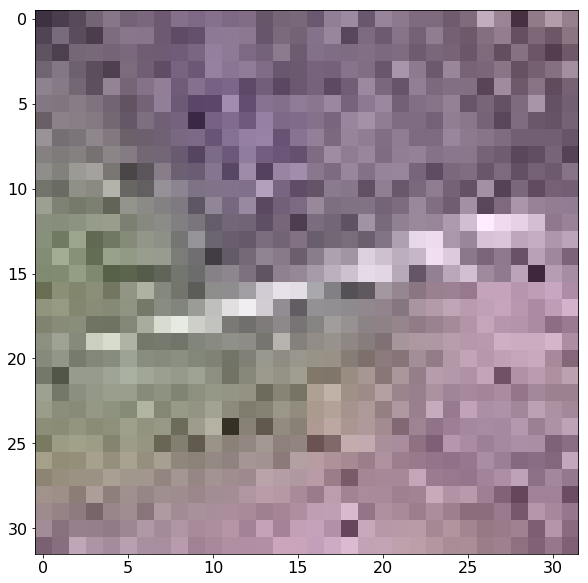

Category: 1.0


In [63]:
# print training and validation sets
print("Train_x shape: " + str(train_x.shape))
print("Train_y shape: " + str(train_y.shape))
plt.imshow(train_x[0])
plt.show()
print("Category: " + str(train_y[0]))

print("Validation set")
print("Valid_x shape: " + str(valid_x.shape))
print("Valid_y shape: " + str(valid_y.shape))
plt.imshow(valid_x[0])
plt.show()
print("Category: %s" % str(valid_y[0]))

In [81]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)
dev_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [82]:
train_generator = train_datagen.flow(
        train_x,
        train_y,
        batch_size= BATCH_SIZE,
        shuffle=True)

In [83]:
dev_generator = dev_datagen.flow(
        valid_x,
        valid_y,
        batch_size= BATCH_SIZE,
        shuffle=True)

## Time for the actual model!
Let's try out Mariam Mohamed's model to start.

In [85]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (5, 5), input_shape=(32, 32, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(64, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(128, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(128, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(512, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Flatten())


model.add(keras.layers.Dense(100))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Dense(1, activation='sigmoid'))

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       204928    
__________

In [87]:
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return keras.callbacks.LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit_generator(
            train_generator, 
            steps_per_epoch= (TRAIN_PICS+BATCH_SIZE-1)//BATCH_SIZE, 
            epochs=30, 
            callbacks=[lr_sched, early_stop])

Epoch 1/30
875/875 [==============================] - 20s 23ms/step - loss: 0.2631 - acc: 0.8923
Epoch 2/30
875/875 [==============================] - 15s 17ms/step - loss: 0.1646 - acc: 0.9364
Epoch 3/30
875/875 [==============================] - 15s 17ms/step - loss: 0.1405 - acc: 0.9444
Epoch 4/30
875/875 [==============================] - 15s 17ms/step - loss: 0.1202 - acc: 0.9526
Epoch 5/30
875/875 [==============================] - 15s 17ms/step - loss: 0.1093 - acc: 0.9570
Epoch 6/30
875/875 [==============================] - 15s 17ms/step - loss: 0.1039 - acc: 0.9597
Epoch 7/30
875/875 [==============================] - 15s 17ms/step - loss: 0.0846 - acc: 0.9696
Epoch 8/30
875/875 [==============================] - 15s 17ms/step - loss: 0.0798 - acc: 0.9711
Epoch 9/30
875/875 [==============================] - 15s 17ms/step - loss: 0.0765 - acc: 0.9721
Epoch 10/30
875/875 [==============================] - 15s 17ms/step - loss: 0.0686 - acc: 0.9771
Epoch 11/30
875/875 [========

In [89]:
res = model.predict_generator(dev_generator, steps =(VALID_PICS+BATCH_SIZE-1)//BATCH_SIZE)
pred = np.argmax(res,axis=1)
print(pred)
print(str(pred.shape))

[0 0 0 ... 0 0 0]
(3500,)


In [90]:
model.evaluate_generator(dev_generator, steps=(VALID_PICS+BATCH_SIZE-1)//BATCH_SIZE)

[0.059240042717395615, 0.9802857142857143]

### And now let's read in the test set.

In [91]:
def read_img_test(filepath, size):
    img = image.load_img(os.path.join(test_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [92]:
'''test = np.zeros((TEST_PICS, IMAGE_SIZE, IMAGE_SIZE, 3))
test_ids = []
count = 0
for file in os.listdir(test_dir):
    img = read_img_test(file, (IMAGE_SIZE, IMAGE_SIZE))
    test[count] = img/255
    test_ids.append(file) # Images' ids
    count += 1
#train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])'''

"test = np.zeros((TEST_PICS, IMAGE_SIZE, IMAGE_SIZE, 3))\ntest_ids = []\ncount = 0\nfor file in os.listdir(test_dir):\n    img = read_img_test(file, (IMAGE_SIZE, IMAGE_SIZE))\n    test[count] = img/255\n    test_ids.append(file) # Images' ids\n    count += 1\n#train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])"

In [93]:
test_files = os.listdir(test_dir)
TEST_PICS = len(test_files)
batch = 40
all_out = []
for i in range(int(TEST_PICS/batch)):
    images = []
    for j in range(batch):
        img = read_img_test(test_files[i*batch + j], (IMAGE_SIZE, IMAGE_SIZE))
        images += [img]
    out = model.predict(np.array(images))
    all_out += [out]

In [94]:
all_out = np.array(all_out).reshape((-1, 1))
all_out.shape

(4000, 1)

In [95]:
sub_file = pd.DataFrame(data = {'id': test_files, 'has_cactus': all_out.reshape(-1).tolist()})

In [96]:
sub_file.to_csv('submission1mariam.csv', index=False)

Test's shape: (4000, 32, 32, 3)


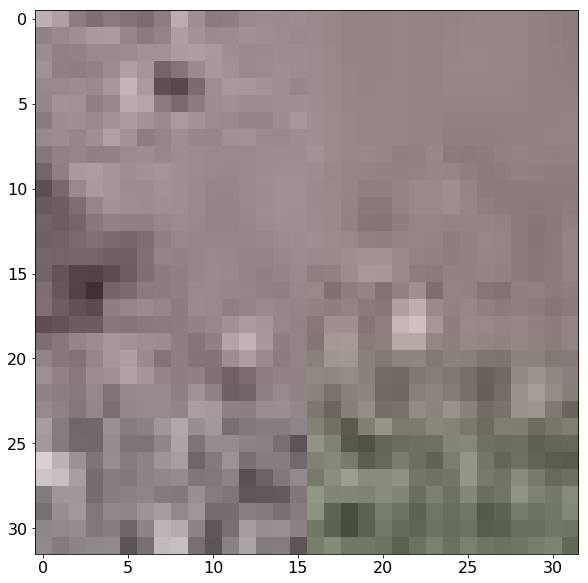

In [66]:
'''print("Test's shape: %s" % str(test.shape))
plt.imshow(test[0])
plt.show()'''

My findings during testing:
- Optimizer? **Adam**. Adadelta does best on train and validation but Adam does best on test.
- Dropout?
- Image size? **128 pixels** seems to be doing well. (Further testing might help)
- Number of convblocks? **11 convblocks** is pretty good. (Further testing might help)
- Reduce learning rate? 
- Batch size? **32 batch size** works the best.
- Epochs? The accuracy continues to improve up to **120 epochs**; I could probably test for longer than 120 epochs and still have it improve. (Further testing might help).